In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm

In [113]:
fl = np.load('../data/processed/embedding.npz')
ids = fl['ids'].astype(int)
embedding = fl['embedding']

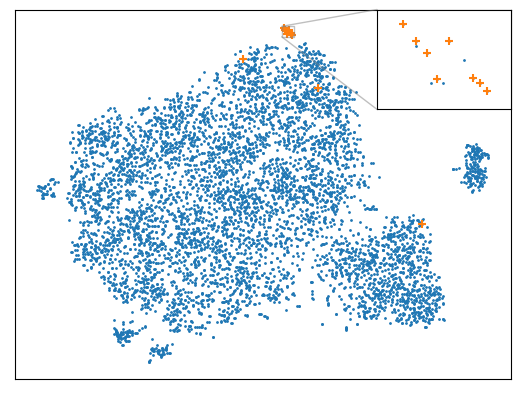

In [129]:
fg, ax = plt.subplots()
insax = ax.inset_axes([.73,.73,.27,.27])
for axis in [ax, insax]:
    axis.scatter(embedding[:,0], embedding[:,1], s=1)
    axis.scatter(
        [embedding[ids==coi,0] for coi in hzq_df.coadd_object_id],
        [embedding[ids==coi,1] for coi in hzq_df.coadd_object_id],
        marker='+'
    )
    axis.set_xticks([])
    axis.set_yticks([])
insax.set_xlim(9.5,13)
insax.set_ylim(47,50)
ax.indicate_inset_zoom(insax);